### 데이터 전처리 수행.
* 학습/검증/테스트 데이터 세트로 나누고 원-핫 인코딩 수행

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd

import random as python_random
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10

# seed 를 설정해서 학습시마다 동일한 결과 유도. 불행히도 의도한 대로 동작하지 않음. 
def set_random_seed(seed_value):
    np.random.seed(seed_value)
    python_random.seed(seed_value)
    tf.random.set_seed(seed_value)

# 0 ~ 1사이값의 float32로 변경하는 함수
def get_preprocessed_data(images, labels):
    
    # 학습과 테스트 이미지 array를 0~1 사이값으로 scale 및 float32 형 변형. 
    images = np.array(images/255.0, dtype=np.float32)
    labels = np.array(labels, dtype=np.float32)
    
    return images, labels

# 0 ~ 1사이값 float32로 변경하는 함수 호출 한 뒤 OHE 적용 
def get_preprocessed_ohe(images, labels):
    images, labels = get_preprocessed_data(images, labels)
    # OHE 적용 
    oh_labels = to_categorical(labels)
    return images, oh_labels

# 학습/검증/테스트 데이터 세트에 전처리 및 OHE 적용한 뒤 반환 
def get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=2021):
    # 학습 및 테스트 데이터 세트를  0 ~ 1사이값 float32로 변경 및 OHE 적용. 
    train_images, train_oh_labels = get_preprocessed_ohe(train_images, train_labels)
    test_images, test_oh_labels = get_preprocessed_ohe(test_images, test_labels)
    
    # 학습 데이터를 검증 데이터 세트로 다시 분리
    tr_images, val_images, tr_oh_labels, val_oh_labels = train_test_split(train_images, train_oh_labels, test_size=valid_size, random_state=random_state)
    
    return (tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels ) 


# random seed는 2021로 고정.
set_random_seed(2021)
# CIFAR10 데이터 재 로딩 및 Scaling/OHE 전처리 적용하여 학습/검증/데이터 세트 생성. 
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)
(tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels) = \
    get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=2021)

print(tr_images.shape, tr_oh_labels.shape, val_images.shape, val_oh_labels.shape, test_images.shape, test_oh_labels.shape)

170508288/170498071 [==============================] - 11s 0us/step
(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)
(42500, 32, 32, 3) (42500, 10) (7500, 32, 32, 3) (7500, 10) (10000, 32, 32, 3) (10000, 10)


In [ ]:
IMAGE_SIZE = 32

### 모델 생성 함수 생성

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam , RMSprop 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler

def create_model(verbose=False):
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

    #x = Conv2D(filters=32, kernel_size=(5, 5), padding='valid', activation='relu')(input_tensor)
    x = Conv2D(filters=32, kernel_size=(3, 3), padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=32, kernel_size=(3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(filters=64, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=64, kernel_size=3, padding='same')(x)
    x = Activation('relu')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=2)(x)

    x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=2)(x)

    # cifar10의 클래스가 10개 이므로 마지막 classification의 Dense layer units갯수는 10
    x = Flatten(name='flatten')(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(300, activation='relu', name='fc1')(x)
    x = Dropout(rate=0.3)(x)
    output = Dense(10, activation='softmax', name='output')(x)

    model = Model(inputs=input_tensor, outputs=output)
    
    if verbose:
        model.summary()
    
    return model

In [ ]:
create_model(verbose=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                             

### Learning Rate와 Early Stopping을 위한 Callback 생성 
* Learning rate 동적 변경은 ReduceLROnPlateau,  모델 Ealry Stopping은 EarlyStopping Callback을 이용.  

In [ ]:
# ModelCheckpoint를 동작시키기 전에 기존 저장된 모델은 모두 삭제 
!rm *.hdf5

rm: cannot remove '*.hdf5': No such file or directory


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = create_model()
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# validation loss가 향상되는 모델만 저장.
mcp_cb = ModelCheckpoint(filepath='./weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', 
                         save_best_only=True, save_weights_only=True, mode='min', period=1, verbose=0)

# 5번 iteration내에 validation loss가 향상되지 않으면 learning rate을 기존 learning rate * 0.2로 줄임.  
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
# 10번 iteration내에 validation loss가 향상되지 않으면 더 이상 학습하지 않고 종료
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)


history = model.fit(x=tr_images, y=tr_oh_labels, batch_size=32, epochs=30, shuffle=True,
                    validation_data=(val_images, val_oh_labels),  
                    callbacks=[mcp_cb, rlr_cb, ely_cb] )

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/30
1329/1329 [==============================] - 29s 20ms/step - loss: 1.5631 - accuracy: 0.4352 - val_loss: 1.3407 - val_accuracy: 0.4972 - lr: 0.0010
Epoch 2/30
1329/1329 [==============================] - 26s 20ms/step - loss: 1.1056 - accuracy: 0.6063 - val_loss: 0.9843 - val_accuracy: 0.6485 - lr: 0.0010
Epoch 3/30
1329/1329 [==============================] - 26s 20ms/step - loss: 0.9246 - accuracy: 0.6759 - val_loss: 1.0312 - val_accuracy: 0.6433 - lr: 0.0010
Epoch 4/30
1329/1329 [==============================] - 25s 19ms/step - loss: 0.8100 - accuracy: 0.7174 - val_loss: 0.8656 - val_accuracy: 0.6881 - lr: 0.0010
Epoch 5/30
1329/1329 [==============================] - 26s 20ms/step - loss: 0.7203 - accuracy: 0.7534 - val_loss: 0.6814 - val_accuracy: 0.7728 - lr: 0.0010
Epoch 6/30
1329/1329 [==============================] - 24s 18ms/step - loss: 0.6516 - accuracy: 0.7757 - val_loss: 0.6949 - val_accuracy: 0.7629 - lr: 0.0010
Epoch 7/30
1329/1329 [========================

In [ ]:
model.evaluate(test_images, test_oh_labels)

313/313 [==============================] - 3s 9ms/step - loss: 0.6137 - accuracy: 0.8527


[0.6136704087257385, 0.8526999950408936]

In [ ]:
!ls -lia

total 28816
2884489 drwxr-xr-x 1 root root    4096 Feb 15 05:22 .
3164439 drwxr-xr-x 1 root root    4096 Feb 15 04:56 ..
3539133 drwxr-xr-x 4 root root    4096 Feb  1 14:31 .config
2884490 drwxr-xr-x 1 root root    4096 Feb  1 14:32 sample_data
2490370 -rw-r--r-- 1 root root 3685760 Feb 15 05:15 weights.01-1.34.hdf5
2490371 -rw-r--r-- 1 root root 3685760 Feb 15 05:16 weights.02-0.98.hdf5
2490372 -rw-r--r-- 1 root root 3685760 Feb 15 05:17 weights.04-0.87.hdf5
2490373 -rw-r--r-- 1 root root 3685760 Feb 15 05:17 weights.05-0.68.hdf5
2490374 -rw-r--r-- 1 root root 3685760 Feb 15 05:18 weights.07-0.62.hdf5
2490375 -rw-r--r-- 1 root root 3685760 Feb 15 05:19 weights.09-0.54.hdf5
2490376 -rw-r--r-- 1 root root 3685760 Feb 15 05:19 weights.10-0.53.hdf5
2490377 -rw-r--r-- 1 root root 3685760 Feb 15 05:22 weights.16-0.49.hdf5


### 최적 weight를 모델로 재 로딩한 다음에 테스트 데이터로 다시 평가

In [ ]:
model = create_model()
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
# 모델 weight를 불러오기전에 모델을 미리 만들어줘야한다.
model.load_weights('./weights.16-0.49.hdf5')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.evaluate(test_images, test_oh_labels)

313/313 [==============================] - 3s 9ms/step - loss: 0.5047 - accuracy: 0.8475


[0.5047208070755005, 0.8475000262260437]

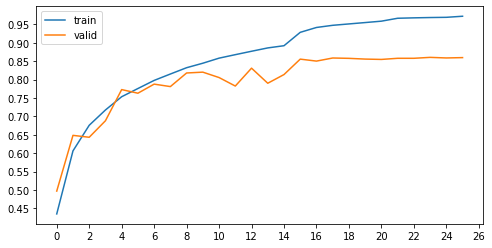

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_history(history):
    plt.figure(figsize=(8, 4))
    plt.yticks(np.arange(0, 1, 0.05))
    plt.xticks(np.arange(0, 30, 2))
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='valid')
    plt.legend()
    
show_history(history)

### 필터의 개수를 증가시켜 테스트
* Conv Layer의 필터를 기존보다 2배씩 증가
* 맨 마지막 Conv는 512로 대폭 증가

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam , RMSprop 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler

input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

#x = Conv2D(filters=32, kernel_size=(5, 5), padding='valid', activation='relu')(input_tensor)
x = Conv2D(filters=64, kernel_size=(3, 3), padding='same')(input_tensor)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=64, kernel_size=(3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
x = Activation('relu')(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(filters=256, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=256, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# 512 filters Conv layer 추가
x = Conv2D(filters=512, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = MaxPooling2D(pool_size=2)(x)

# cifar10의 클래스가 10개 이므로 마지막 classification의 Dense layer units갯수는 10
x = Flatten(name='flatten')(x)
x = Dropout(rate=0.5)(x)
x = Dense(300, activation='relu', name='fc1')(x)
x = Dropout(rate=0.3)(x)
output = Dense(10, activation='softmax', name='output')(x)

model = Model(inputs=input_tensor, outputs=output)

model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization_20 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                                
                                                                 
 activation_28 (Activation)  (None, 32, 32, 64)        0         
                                                                 
 conv2d_25 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_21 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                          

In [ ]:
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# 5번 iteration내에 validation loss가 향상되지 않으면 learning rate을 기존 learning rate * 0.2로 줄임.  
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
# 10번 iteration내에 validation loss가 향상되지 않으면 더 이상 학습하지 않고 종료
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)


history = model.fit(x=tr_images, y=tr_oh_labels, batch_size=32, epochs=30, shuffle=True,
                    validation_data=(val_images, val_oh_labels),  
                    callbacks=[rlr_cb, ely_cb] )

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/30
1329/1329 [==============================] - 47s 34ms/step - loss: 2.0569 - accuracy: 0.2320 - val_loss: 1.6358 - val_accuracy: 0.3789 - lr: 0.0010
Epoch 2/30
1329/1329 [==============================] - 44s 33ms/step - loss: 1.5970 - accuracy: 0.3746 - val_loss: 1.4455 - val_accuracy: 0.4437 - lr: 0.0010
Epoch 3/30
1329/1329 [==============================] - 44s 33ms/step - loss: 1.4013 - accuracy: 0.4467 - val_loss: 1.2486 - val_accuracy: 0.5548 - lr: 0.0010
Epoch 4/30
1329/1329 [==============================] - 44s 33ms/step - loss: 1.2571 - accuracy: 0.5201 - val_loss: 0.9732 - val_accuracy: 0.6824 - lr: 0.0010
Epoch 5/30
1329/1329 [==============================] - 44s 33ms/step - loss: 1.1219 - accuracy: 0.5824 - val_loss: 0.8808 - val_accuracy: 0.6925 - lr: 0.0010
Epoch 6/30
1329/1329 [==============================] - 44s 33ms/step - loss: 1.0328 - accuracy: 0.6195 - val_loss: 0.8857 - val_accuracy: 0.7080 - lr: 0.0010
Epoch 7/30
1329/1329 [========================

313/313 [==============================] - 4s 12ms/step - loss: 0.8679 - accuracy: 0.8592


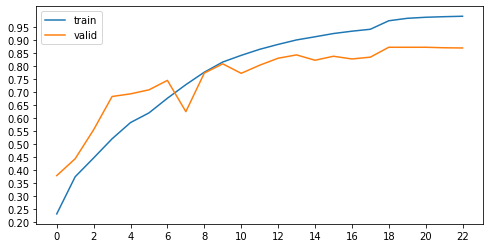

In [ ]:
model.evaluate(test_images, test_oh_labels)
show_history(history)

### 맨 마지막 Conv + MaxPooling 대신 맨 마지막 Conv의 Strides를 2로 하여 Feature map 조정

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam , RMSprop 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler

input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

x = Conv2D(filters=64, kernel_size=(3, 3), padding='same')(input_tensor)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=64, kernel_size=(3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
x = Activation('relu')(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(filters=256, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=256, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# 512 filters Conv layer 추가하되 이후 MaxPooling을 적용하지 않고 strides는 2로 변경하여 출력 feature map 크기 조정
x = Conv2D(filters=512, kernel_size=3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)


# cifar10의 클래스가 10개 이므로 마지막 classification의 Dense layer units갯수는 10
x = Flatten(name='flatten')(x)
x = Dropout(rate=0.5)(x)
x = Dense(300, activation='relu', name='fc1')(x)
x = Dropout(rate=0.3)(x)
output = Dense(10, activation='softmax', name='output')(x)

model = Model(inputs=input_tensor, outputs=output)

model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_31 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization_26 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                                
                                                                 
 activation_36 (Activation)  (None, 32, 32, 64)        0         
                                                                 
 conv2d_32 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_27 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                          

In [17]:
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# 5번 iteration내에 validation loss가 향상되지 않으면 learning rate을 기존 learning rate * 0.2로 줄임.  
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
# 10번 iteration내에 validation loss가 향상되지 않으면 더 이상 학습하지 않고 종료
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)


history = model.fit(x=tr_images, y=tr_oh_labels, batch_size=32, epochs=30, shuffle=True,
                    validation_data=(val_images, val_oh_labels),  
                    callbacks=[rlr_cb, ely_cb] )

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/30
1329/1329 [==============================] - 48s 35ms/step - loss: 1.6746 - accuracy: 0.3797 - val_loss: 1.5706 - val_accuracy: 0.4105 - lr: 0.0010
Epoch 2/30
1329/1329 [==============================] - 47s 35ms/step - loss: 1.2250 - accuracy: 0.5573 - val_loss: 1.1648 - val_accuracy: 0.6141 - lr: 0.0010
Epoch 3/30
1329/1329 [==============================] - 46s 35ms/step - loss: 0.9973 - accuracy: 0.6496 - val_loss: 1.0820 - val_accuracy: 0.6329 - lr: 0.0010
Epoch 4/30
1329/1329 [==============================] - 46s 35ms/step - loss: 0.8550 - accuracy: 0.7052 - val_loss: 0.8211 - val_accuracy: 0.7243 - lr: 0.0010
Epoch 5/30
1329/1329 [==============================] - 46s 35ms/step - loss: 0.7384 - accuracy: 0.7493 - val_loss: 1.0202 - val_accuracy: 0.6748 - lr: 0.0010
Epoch 6/30
1329/1329 [==============================] - 47s 35ms/step - loss: 0.6373 - accuracy: 0.7864 - val_loss: 0.6880 - val_accuracy: 0.7699 - lr: 0.0010
Epoch 7/30
1329/1329 [========================

313/313 [==============================] - 3s 11ms/step - loss: 0.8913 - accuracy: 0.8622


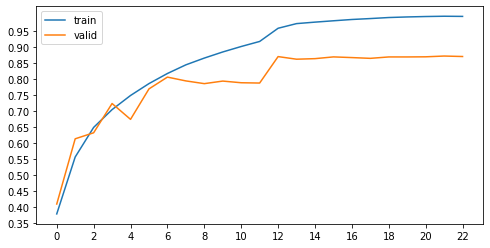

In [18]:
model.evaluate(test_images, test_oh_labels)
show_history(history)

### Global Average Pooling의 적용
* Global Average Pooling은 피처맵의 가로x세로의 특정 영역을 Sub sampling 않고, 채널별로 평균 값을 추출(Global의 의미가 채널을 뜻함)
* 충분히 Feature map의 채널수가 많을 경우 이를 적용. 채널수가 적다면 Flatten이 유리. 
* Flatten-> Classification Dense Layer로 이어지면서 많은 파라미터들로 인한 오버피팅 유발 가능성 증대 및 학습 시간 늘어남. 
* 맨 마지막 Feature Map의 채널 수가 충분히 크다면 GlobalAveragePooling2D를 적용하여 Flatten을 제거하는데 더 유리 할 수 있음.  (512정도는 되야 쓸만하다)

In [19]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam , RMSprop 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler

input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

#x = Conv2D(filters=32, kernel_size=(5, 5), padding='valid', activation='relu')(input_tensor)
x = Conv2D(filters=64, kernel_size=(3, 3), padding='same')(input_tensor)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=64, kernel_size=(3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
x = Activation('relu')(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(filters=256, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=256, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=512, kernel_size=3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# Flatten 대신 Global AveragePooling 을 적용. 
x = GlobalAveragePooling2D()(x)
x = Dropout(rate=0.5)(x)
x = Dense(50, activation='relu', name='fc1')(x)
x = Dropout(rate=0.2)(x)
output = Dense(10, activation='softmax', name='output')(x)

model = Model(inputs=input_tensor, outputs=output)

model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_38 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization_32 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                                
                                                                 
 activation_44 (Activation)  (None, 32, 32, 64)        0         
                                                                 
 conv2d_39 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_33 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                          

In [20]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# 5번 iteration내에 validation loss가 향상되지 않으면 learning rate을 기존 learning rate * 0.2로 줄임.  
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
# 10번 iteration내에 validation loss가 향상되지 않으면 더 이상 학습하지 않고 종료
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)


history = model.fit(x=tr_images, y=tr_oh_labels, batch_size=32, epochs=30, shuffle=True,
                    validation_data=(val_images, val_oh_labels),  
                    callbacks=[rlr_cb, ely_cb] )

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/30
1329/1329 [==============================] - 50s 36ms/step - loss: 1.5145 - accuracy: 0.4466 - val_loss: 1.7663 - val_accuracy: 0.4276 - lr: 0.0010
Epoch 2/30
1329/1329 [==============================] - 44s 33ms/step - loss: 1.0565 - accuracy: 0.6278 - val_loss: 1.4426 - val_accuracy: 0.5247 - lr: 0.0010
Epoch 3/30
1329/1329 [==============================] - 45s 34ms/step - loss: 0.8562 - accuracy: 0.7044 - val_loss: 0.7817 - val_accuracy: 0.7271 - lr: 0.0010
Epoch 4/30
1329/1329 [==============================] - 45s 34ms/step - loss: 0.7156 - accuracy: 0.7575 - val_loss: 0.9647 - val_accuracy: 0.6853 - lr: 0.0010
Epoch 5/30
1329/1329 [==============================] - 45s 34ms/step - loss: 0.6115 - accuracy: 0.7932 - val_loss: 0.7513 - val_accuracy: 0.7468 - lr: 0.0010
Epoch 6/30
1329/1329 [==============================] - 45s 34ms/step - loss: 0.5252 - accuracy: 0.8257 - val_loss: 0.7928 - val_accuracy: 0.7580 - lr: 0.0010
Epoch 7/30
1329/1329 [========================

313/313 [==============================] - 4s 12ms/step - loss: 0.8206 - accuracy: 0.8619


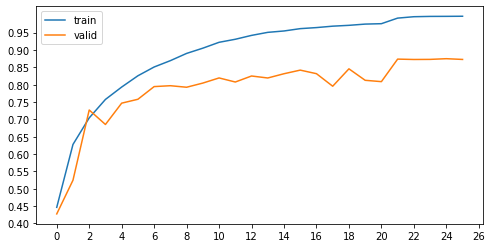

In [21]:
model.evaluate(test_images, test_oh_labels)
show_history(history)

### 가중치 규제(Weight Regularizations)
* 개별 layer별로 tensorflow.keras.regularizers의 l1, l2, l1_l2 를 이용하여 가중치 규제를 적용할 수 있음. 

In [22]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam , RMSprop 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler
from tensorflow.keras.regularizers import l1, l2, l1_l2

input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
# 강사님 기준에선 이미지쪽은 규제의 효과를 잘 모르시겠다 함
x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.00001))(input_tensor)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.00001))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=128, kernel_size=3, padding='same', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=128, kernel_size=3, padding='same', kernel_regularizer=l2(1e-5))(x)
x = Activation('relu')(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(filters=256, kernel_size=3, padding='same', kernel_regularizer=l2(1e-5))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=256, kernel_size=3, padding='same', kernel_regularizer=l2(1e-5))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# 512 filters Conv layer 추가하되 이후 MaxPooling을 적용하지 않고 strides는 2로 변경하여 출력 feature map 크기 조정
x = Conv2D(filters=512, kernel_size=3, strides=2, padding='same', kernel_regularizer=l2(1e-5))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)


# cifar10의 클래스가 10개 이므로 마지막 classification의 Dense layer units갯수는 10
x = Flatten(name='flatten')(x)
x = Dropout(rate=0.5)(x)
x = Dense(300, activation='relu', kernel_regularizer=l2(1e-5), name='fc1')(x)
x = Dropout(rate=0.3)(x)
output = Dense(10, activation='softmax', name='output')(x)

model = Model(inputs=input_tensor, outputs=output)

model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_45 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization_38 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                                
                                                                 
 activation_52 (Activation)  (None, 32, 32, 64)        0         
                                                                 
 conv2d_46 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_39 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                          

In [23]:
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# 5번 iteration내에 validation loss가 향상되지 않으면 learning rate을 기존 learning rate * 0.2로 줄임.  
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
# 10번 iteration내에 validation loss가 향상되지 않으면 더 이상 학습하지 않고 종료
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)


history = model.fit(x=tr_images, y=tr_oh_labels, batch_size=32, epochs=30, shuffle=True,
                    validation_data=(val_images, val_oh_labels),  
                    callbacks=[rlr_cb, ely_cb] )

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/30
1329/1329 [==============================] - 51s 37ms/step - loss: 1.6808 - accuracy: 0.4015 - val_loss: 1.4284 - val_accuracy: 0.5021 - lr: 0.0010
Epoch 2/30
1329/1329 [==============================] - 49s 37ms/step - loss: 1.2393 - accuracy: 0.5776 - val_loss: 1.4448 - val_accuracy: 0.5459 - lr: 0.0010
Epoch 3/30
1329/1329 [==============================] - 50s 37ms/step - loss: 1.0570 - accuracy: 0.6563 - val_loss: 0.9909 - val_accuracy: 0.6912 - lr: 0.0010
Epoch 4/30
1329/1329 [==============================] - 49s 37ms/step - loss: 0.9478 - accuracy: 0.7048 - val_loss: 0.8654 - val_accuracy: 0.7449 - lr: 0.0010
Epoch 5/30
1329/1329 [==============================] - 49s 37ms/step - loss: 0.8721 - accuracy: 0.7436 - val_loss: 0.8664 - val_accuracy: 0.7565 - lr: 0.0010
Epoch 6/30
1329/1329 [==============================] - 50s 37ms/step - loss: 0.7907 - accuracy: 0.7785 - val_loss: 1.3197 - val_accuracy: 0.6675 - lr: 0.0010
Epoch 7/30
1329/1329 [========================

313/313 [==============================] - 4s 13ms/step - loss: 0.9450 - accuracy: 0.8680


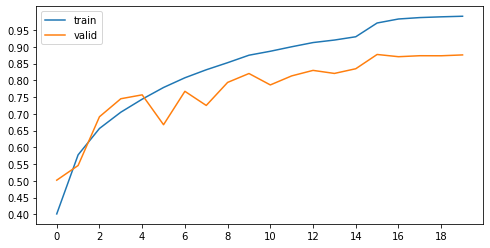

In [24]:
model.evaluate(test_images, test_oh_labels)
show_history(history)